In [2]:
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
# import sklearn_crfsuite
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification


c:\Users\nasser\.conda\envs\finall\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('data/raw/data.csv')

In [4]:
df = df[['text', 'label']]

In [5]:
df.sample(1)

,text,label
5458,PHOENIX has doctor JamesGilbert his speciality...,B-City O O B-Name O O O B-Speciality O O O O O...


In [6]:
data = df

In [7]:
data['label'] = data['label'].astype(str)
data['label'] = data['label'].apply(lambda x: x.split())

In [8]:
data['len(text)'] = data['text'].apply(lambda x: len(x.split()))
data['len(label)'] = data['label'].apply(lambda x: len(x))

In [9]:
# drop any rows where the length of the text and label are not equal
data = data.drop(data[data['len(text)'] != data['len(label)']].index)

In [10]:
data = data.drop(['len(text)', 'len(label)'], axis=1)

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
# Split the data into training and validation datasets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
# Tokenize the input sequence
input_tokenizer = Tokenizer( oov_token='UNK')
input_tokenizer.fit_on_texts(train_data['text'])
train_input_seq = input_tokenizer.texts_to_sequences(train_data['text'])
val_input_seq = input_tokenizer.texts_to_sequences(val_data['text'])

In [13]:
# Tokenize the output sequence
output_tokenizer = Tokenizer(filters='', lower=False)
output_tokenizer.fit_on_texts(train_data['label'])
train_output_seq = output_tokenizer.texts_to_sequences(train_data['label'])
val_output_seq = output_tokenizer.texts_to_sequences(val_data['label'])

In [14]:
# Create word to index and index to word mappings for the input sequence
input_word2idx = input_tokenizer.word_index
input_idx2word = {idx: word for word, idx in input_word2idx.items()}

In [15]:
# Create named entity to index and index to named entity mappings for the output sequence
output_word2idx = output_tokenizer.word_index
output_idx2word = {idx: word for word, idx in output_word2idx.items()}

In [16]:
# Pad the input sequence
max_input_len = max(len(seq) for seq in train_input_seq)
train_input_seq = pad_sequences(train_input_seq, maxlen=max_input_len, padding='post')
val_input_seq = pad_sequences(val_input_seq, maxlen=max_input_len, padding='post')

In [17]:
max_input_len
# Pad the output sequence
max_output_len = max(len(seq) for seq in train_output_seq)
train_output_seq = pad_sequences(train_output_seq, maxlen=max_output_len, padding='post')
val_output_seq = pad_sequences(val_output_seq, maxlen=max_output_len, padding='post')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

In [18]:
# Define the input and output dimensions for the model
input_dim = len(input_word2idx) + 1
output_dim = len(output_word2idx) + 1
# Define the embedding dimension
embedding_dim = 128

In [19]:
# Define the number of hidden units in the LSTM layer
hidden_units = 256
# import bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
# import concatenate
from tensorflow.keras.layers import Concatenate,Input

In [20]:

from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.models import Model


In [21]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Flatten, GRU, Attention

inputs = Input(shape=(max_input_len,))

# Define the embedding layer
embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)



# Define the Bidirectional GRU layer
gru1 = Bidirectional(GRU(hidden_units, return_sequences=True))(embedding)
ltsm1 = Bidirectional(LSTM(hidden_units, return_sequences=True))(embedding)

# Add attention layer
attention = Attention()([gru1, ltsm1])

# Add dense layers
dense = Dense(256, activation='relu')(attention)
dense = BatchNormalization()(dense)
dropout = Dropout(0.5)(dense)


# Define the output layer
outputs = Dense(output_dim, activation='softmax')(dropout)

# Define the model
model = Model(inputs=inputs, outputs=outputs)


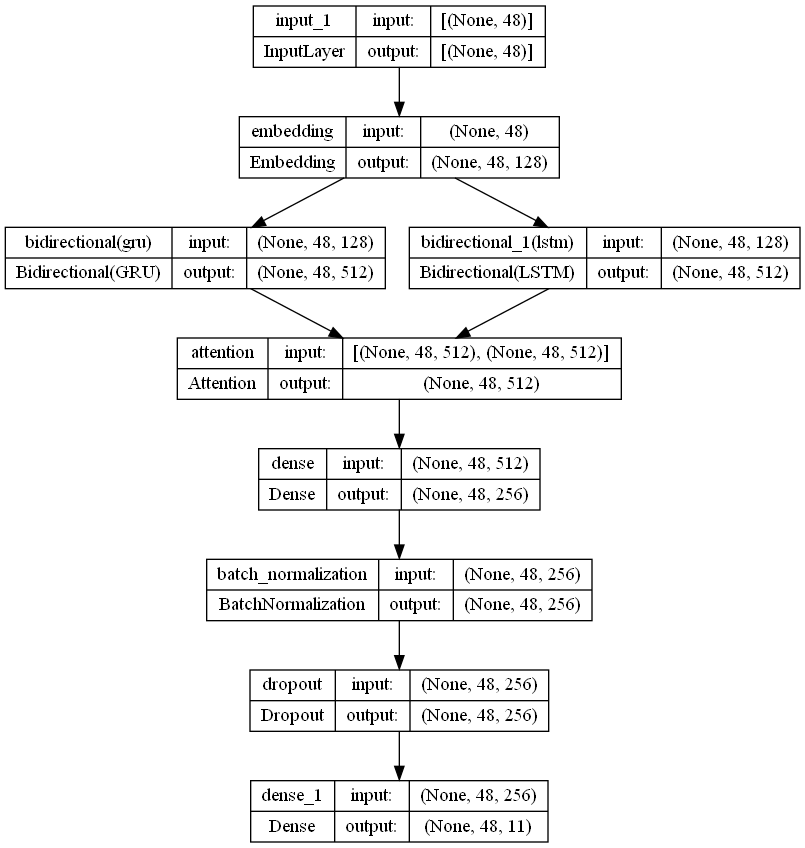

In [22]:
# draw the model
from tensorflow.keras.utils import plot_model
# draw it in the notebook
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
# Compile the model
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01  # Set the learning rate to 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=2048, epochs=15)

Epoch 1/15
10/18 [===============>..............] - ETA: 1s - loss: 1.8452 - accuracy: 0.4748

KeyboardInterrupt: 

In [ ]:

# print the accuracy
print("Accuracy: ", history.history['accuracy'][-1])
# print the accuracy of validation set
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Accuracy:  0.9997313022613525
Validation Accuracy:  0.9991001486778259


In [ ]:
import re

In [24]:
max_input_len

48

In [36]:
import numpy as np
# Use the model to make predictions on new input data
text = "MelissaDodrill and he has fees of 67 $ he is special in Family Practice / General Practice his working hours are: 9-14, he do his job in SHINNSTON"
text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
# remove any extra space
text = re.sub(r'\s+', ' ', text)# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=max_input_len, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)

pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 1s 811ms/step
['B-Name', 'O', 'O', 'O', 'O', 'O', 'B-Cost', 'O', 'O', 'O', 'O', 'B-Speciality', 'I-Speciality', 'I-Speciality', 'I-Speciality', 'O', 'O', 'O', 'O', 'B-Shour', 'B-Ehour', 'O', 'O', 'O', 'O', 'O', 'B-City', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
MelissaDodrill -> B-Name
and -> O
he -> O
has -> O
fees -> O
of -> O
67 -> B-Cost
he -> O
is -> O
special -> O
in -> O
Family -> B-Speciality
Practice -> I-Speciality
General -> I-Speciality
Practice -> I-Speciality
his -> O
working -> O
hours -> O
are -> O
9 -> B-Shour
14 -> B-Ehour
he -> O
do -> O
his -> O
job -> O
in -> O
SHINNSTON -> B-City


In [37]:
# save the model
model.save('models/ner_model.h5')

In [39]:
# save the tokenizer
import joblib
joblib.dump(input_tokenizer, 'models/input_tokenizer.pkl')

['models/input_tokenizer.pkl']

In [41]:
# save the output_idx2word using joblib
joblib.dump(output_idx2word, 'models/output_idx2word.pkl')


['models/output_idx2word.pkl']